In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow import keras
import sys
import PIL
import os
import tensorflow.keras.backend as K
import sys
sys.path.append('../scripts/helper_functions_cv/tensorflow_helpers/')
from gpu_starter_mirror_strategy import start_gpus
from sklearn.model_selection import train_test_split
import collections
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from sklearn.utils import compute_class_weight
import tensorflow_datasets as tfds

In [2]:
strategy = tf.distribute.MirroredStrategy()
REPLICAS = strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [4]:
# train_csv = pd.read_csv('../data/train.csv')

In [5]:
# def fix_csv_paths(data):
#     return '../data/fixed_pngs/' + str(data.patient_id) + '/' + str(data.image_id) + '.png'

In [6]:
# train_csv['updated_paths'] = train_csv.apply(fix_csv_paths, axis = 1)

In [7]:
# train_csv.head()

In [8]:
# def create_splits(csv_data):
#     train, test = train_test_split(csv_data, test_size = 0.01)
#     train, val = train_test_split(train, test_size = 0.01)
#     return train, val, test

In [9]:
# train, val, test = create_splits(train_csv)

Read tfrec record from this path

In [13]:
def decode_tfrec_record(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "label": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
        "file_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = example['image']
    label = example['label']
    file_name = example['file_name']
    return image, label, file_name

In [15]:
def read_tfrec(tfrec_path, decode_function):
    dataset = tf.data.TFRecordDataset(tfrec_path)
    dataset = dataset.map(decode_function)
    return dataset

In [17]:
tfrec_data = read_tfrec('../data/train_1024.tfrec', decode_tfrec_record)

In [21]:
tfrec_data

<MapDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [12]:
# counter_dict = collections.Counter(train['cancer'].values.tolist())
# key = list(counter_dict.keys())
# values = list(counter_dict.values())
# plt.bar(key, values)

<BarContainer object of 2 artists>

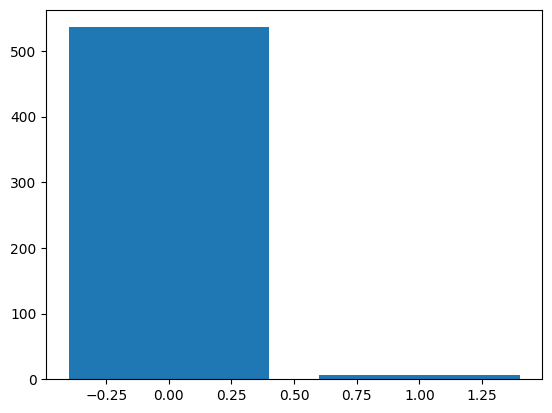

In [10]:
counter_dict = collections.Counter(val['cancer'].values.tolist())
key = list(counter_dict.keys())
values = list(counter_dict.values())
plt.bar(key, values)

<BarContainer object of 2 artists>

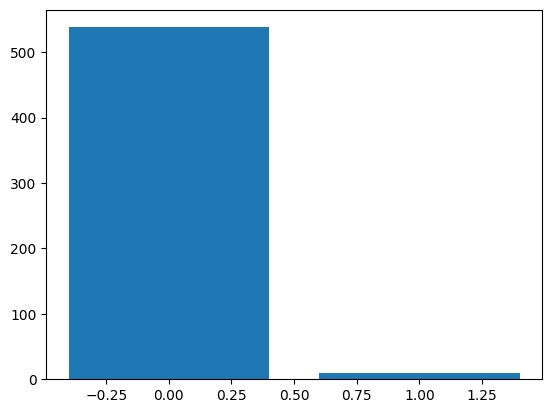

In [11]:
counter_dict = collections.Counter(test['cancer'].values.tolist())
key = list(counter_dict.keys())
values = list(counter_dict.values())
plt.bar(key, values)

In [12]:
for x in train_csv['updated_paths'].values.tolist():
    if os.path.exists(x) == False:
        print(x)

In [13]:
train_imgs = train['updated_paths'].values.tolist()
train_labs = train['cancer'].values.tolist()

In [14]:
def read_train_imgs(img, label):
    img = tf.io.read_file(img)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, size = (256, 256))
    img = img / 255
    return img, label

In [15]:
def get_data(**kwargs):
    imgs = kwargs['csv_file']['updated_paths'].values.tolist()
    labels = kwargs['csv_file']['cancer'].values.tolist()
    tensor = tf.data.Dataset.from_tensor_slices((imgs, labels))
    tensor = tensor.cache()
    if kwargs['repeat'] == True:
        tensor = tensor.repeat()
    if kwargs['shuffle'] == True:
        tensor = tensor.shuffle(1024 * REPLICAS)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        tensor = tensor.with_options(opt)
    # if kwargs['train']:
    tensor = tensor.map(read_train_imgs, num_parallel_calls = AUTO)
    # elif kwargs['val']:
        # tensor = tensor.map(get_train_imgs, num_parallel_calls = AUTO)
    if kwargs['batch'] == True:
        tensor = tensor.batch(kwargs['batch_size'] * REPLICAS)
    if kwargs['prefetch'] == True:
        tensor = tensor.prefetch(AUTO)
    return tensor

In [16]:
train_args_dict = {
    'csv_file': train,
    'repeat': True,
    'shuffle': True,
    'batch': True,
    'prefetch': True,
    'batch_size': 128
}
train_dataset = get_data(**train_args_dict)

In [17]:
def create_model(model_name, shape):
    with strategy.scope():
        input_layer = tf.keras.Input(shape = shape)
        construct = getattr(keras.applications, model_name)
        mid_layer = construct(include_top = False, 
            weights = None, 
            pooling = 'avg',
            input_shape = shape)(input_layer)
        last_layer = keras.layers.Dense(1, activation = 'sigmoid')(mid_layer)
        model = keras.Model(input_layer, last_layer)
    return model
def compile_new_model(model):
    with strategy.scope():
        loss = keras.losses.BinaryCrossentropy()
        optimizer = keras.optimizers.SGD()
        prec = keras.metrics.Precision(name = 'prec')
        rec = keras.metrics.Recall(name = 'rec')
        model.compile(
            loss = loss,
            optimizer = optimizer,
            metrics = [prec, rec]
        )
    return model

In [18]:
train_labels = train['cancer'].values.tolist()

In [19]:
computed_weights = compute_class_weight(class_weight='balanced', classes=[0,1], y = train_labels)

In [20]:
weights_dict = {
    0: computed_weights[0],
    1: computed_weights[1]
}

In [21]:
K.clear_session()
train_args_dict = {
    'csv_file': train,
    'repeat': True,
    'shuffle': True,
    'batch': True,
    'prefetch': True,
    'batch_size': 128
}
val_args_dict = {
    'csv_file': val,
    'repeat': False,
    'shuffle': False,
    'batch': True,
    'prefetch': True,
    'batch_size': 128
}
train_dataset = get_data(**train_args_dict)
val_dataset = get_data(**val_args_dict)
with strategy.scope():
    model = create_model('ResNet50', (256, 256, 1))
    model = compile_new_model(model)
modelHist = model.fit(
    train_dataset,
    steps_per_epoch = len(train) // (REPLICAS * 128),
    epochs = 50,
    verbose = 1,
    validation_data = val_dataset
)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2023-03-16 18:12:02.107293: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 53616
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:8"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
      args {
       

UnimplementedError: Graph execution error:

Detected at node 'model/resnet50/conv1_conv/Conv2D' defined at (most recent call last):
    File "/usr/lib/python3.8/threading.py", line 890, in _bootstrap
      self._bootstrap_inner()
    File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
      self.run()
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/engine/training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/layers/convolutional/base_conv.py", line 250, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/layers/convolutional/base_conv.py", line 225, in convolution_op
      return tf.nn.convolution(
Node: 'model/resnet50/conv1_conv/Conv2D'
Detected at node 'model/resnet50/conv1_conv/Conv2D' defined at (most recent call last):
    File "/usr/lib/python3.8/threading.py", line 890, in _bootstrap
      self._bootstrap_inner()
    File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
      self.run()
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/engine/training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/layers/convolutional/base_conv.py", line 250, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/home/ubuntu/test_env/lib/python3.8/site-packages/keras/layers/convolutional/base_conv.py", line 225, in convolution_op
      return tf.nn.convolution(
Node: 'model/resnet50/conv1_conv/Conv2D'
2 root error(s) found.
  (0) UNIMPLEMENTED:  DNN library is not found.
	 [[{{node model/resnet50/conv1_conv/Conv2D}}]]
	 [[div_no_nan_2/ReadVariableOp/_182]]
  (1) UNIMPLEMENTED:  DNN library is not found.
	 [[{{node model/resnet50/conv1_conv/Conv2D}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_17031]

In [ ]:
# sudo apt-get install libcudnn8=8.6.0.163-1+cuda11.8

In [ ]:
tf.__version__

'2.11.0'